In this final article, we will attempt to compare the performance of the different eth2 clients participating in the Medalla testnet. These clients are:

- [Prysm](https://github.com/prysmaticlabs/prysm) from [Prysmatic Labs](https://prysmaticlabs.com/)
- [Lighthouse](https://github.com/sigp/lighthouse) from [Sigma Prime](https://sigmaprime.io/)
- [Teku](https://github.com/PegaSysEng/teku) from [PegaSys](https://pegasys.tech/)
- [Nimbus](https://github.com/status-im/nimbus) from [Status.im](https://status.im/)
- [Lodestar](https://github.com/ChainSafe/lodestar) from [Chainsafe](https://chainsafe.io/)

We've already made a guess at which client each validator was running as part of [data pre-processing](/posts/medalla-data-prep), we'll now take a look at how they compared.

This work comes with many caveats. Firstly, as already mentioned, this analysis relies on the truthfulness of validators' block graffiti. Secondly, our analysis will impacted by the type of hardware, and perhaps even the type of user, for each client. For example, Nimbus has been promoted as a client targeted at minimal hardware (phones, Raspberry Pis etc.), so we might expect that a typical Nimbus user will be running lower-powered hardware. At the other end of the spectrum, Teku has been promoted as an enterprise solution. Perhaps therefore a typical Teku user will be running more powerful computers. Finally, the available data constitutes a snapshot in time, so we should be cautious about projecting forwards the result of analysis on this dataset into the future. All the eth2 clients have continued to be developed and refined throughout the period under review. Where problems with a particular client are apparent in this data, they may already be resolved in the latest client release.

Nonetheless, there we may be able to make some useful obvservations based on the client-identifying data available to us. So one last time, let's get started with the Python imports and database connection:

In [1]:
# imports
import math
import time

import psycopg2
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, clear_output

In [2]:
# open/restart connection to chaind database
try:
    cursor.close()
    connection.close()
except:
    pass

connection = psycopg2.connect(user="chain", host="127.0.0.1", database="chain", password="medalla")
cursor = connection.cursor()

In [3]:
# get info about dataset and validators

cursor.execute("SELECT MAX(f_slot) FROM t_blocks")
latest_slot = cursor.fetchone()[0]
n_slots = latest_slot + 1
n_epochs = (n_slots - (n_slots % 32)) // 32

cursor.execute("SELECT f_activation_eligibility_epoch, f_activation_epoch, f_exit_epoch, f_slashed, "
               "f_first_attested_epoch, f_latest_attested_epoch, f_client, f_proposed_count "
               "FROM t_validators ORDER BY f_index")
result = cursor.fetchall()
validators = [{"activation_eligibility_epoch": r[0],
               "activation_epoch"            : r[1],
               "exit_epoch"                  : r[2],
               "slashed"                     : r[3],
               "first_attestation"           : r[4],
               "latest_attestation"          : r[5],
               "client"                      : r[6],
               "proposed_count"              : r[7]} for r in result]

## Client proportions
Summarising the distribution of clients inferred from block graffiti, we found that the majority of validators (72%) did not provide information in block graffiti which could be used to identify the client used. This includes all validators which did not propose any blocks, since graffiti is only supplied by the block producer. For this reason, validators who were *absent* or those which did not participate long enough to propose any blocks, are excluded.

Number of validators: 80328
22347 provided client info (27.8%)
41693 no info (51.9%)
16288 no blocks produced (20.3%)


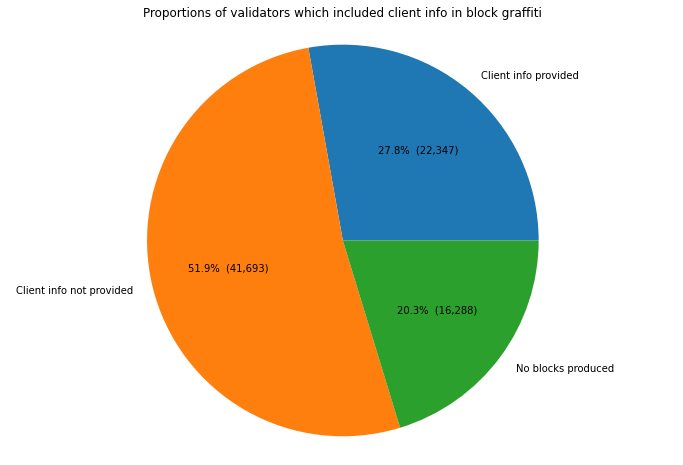

In [4]:
# plot validator counts

pr_count = li_count = te_count = ni_count = lo_count = amb_count = 0
for validator in validators:
    if validator["client"] == "prysm":
        pr_count += 1
    elif validator["client"] == "lighthouse":
        li_count += 1
    elif validator["client"] == "teku":
        te_count += 1
    elif validator["client"] == "nimbus":
        ni_count += 1
    elif validator["client"] == "lodestar":
        lo_count += 1
    elif validator["client"] == "ambiguous":
        amb_count += 1

no_blocks_count = sum(v["proposed_count"] == 0  for v in validators)
no_info_count   = sum(v["client"]         == "" for v in validators) - no_blocks_count
client_info_count = len(validators) - no_blocks_count - no_info_count

print(f"Number of validators: {len(validators)}")
print(f"{client_info_count:5} provided client info ({100*client_info_count/len(validators):.1f}%)")
print(f"{no_info_count:5} no info ({100*no_info_count/len(validators):.1f}%)")
print(f"{no_blocks_count:5} no blocks produced ({100*no_blocks_count/len(validators):.1f}%)")

labels = ['Client info provided', 'Client info not provided', 'No blocks produced']
counts = [client_info_count, no_info_count, no_blocks_count]
fig0, ax0 = plt.subplots(figsize=(12,8))
ax0.pie(counts, labels=labels, autopct=lambda p: f"{p:.1f}%  ({p * sum(counts)/100:,.0f})")
ax0.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Proportions of validators which included client info in block graffiti')
plt.show()

The 28% of validators did include identifying information in graffiti will be the focus of the rest of this article. As shown below, almost 10% of these validators provided ambiguous information (i.e. they indicated different clients and different times), so we have no choice but to exclude these from further analysis.

With that done, we find that Prysm nodes made up almost half of the validators, Lighthouse a third, and the remainining ⅙ were split almost evenly between Nimbus and Teku. The number of Lodestar clients is so small that these will also be excluded from the following analysis. These numbers seem believable based on anecdotal reports of clients being used — certainly the ranking seems likely — but ultimately we have no way of checking them.

Number of validators providing client info: 22347
10046 Prysm (45.0%)
 6656 Lighthouse (29.8%)
 1869 Teku (8.4%)
 1500 Nimbus (6.7%)
   99 Lodestar (0.4%)
 2177 ambiguous (9.7%)


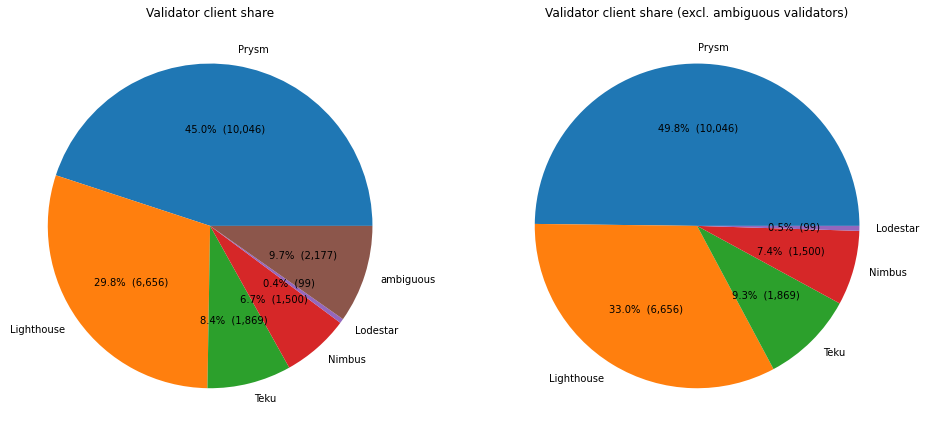

In [5]:
# plot validator client share

print(f"Number of validators providing client info: {client_info_count}")
print(f"{pr_count:5} Prysm ({     100*pr_count  / client_info_count:.1f}%)")
print(f"{li_count:5} Lighthouse ({100*li_count  / client_info_count:.1f}%)")
print(f"{te_count:5} Teku ({      100*te_count  / client_info_count:.1f}%)")
print(f"{ni_count:5} Nimbus ({    100*ni_count  / client_info_count:.1f}%)")
print(f"{lo_count:5} Lodestar ({  100*lo_count  / client_info_count:.1f}%)")
print(f"{amb_count:5} ambiguous ({100*amb_count / client_info_count:.1f}%)")


fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,10))


labels = ['Prysm', 'Lighthouse', 'Teku', 'Nimbus', 'Lodestar', 'ambiguous']
counts = [pr_count, li_count, te_count, ni_count, lo_count, amb_count]
#ax1 = fig.add_axes([0, 0, 2, 2], aspect=1)
#ax1 = fig.add_subplot(123)
ax1.pie(counts, labels=labels, autopct=lambda p: f"{p:.1f}%  ({p * sum(counts)/100:,.0f})")
ax1.set_title('Validator client share')

labels = ['Prysm', 'Lighthouse', 'Teku', 'Nimbus', 'Lodestar']
counts = [pr_count, li_count, te_count, ni_count, lo_count]
#ax2 = fig.add_axes([2, 0, 2, 2], aspect=1)
#ax2 = fig.add_subplot(124)
ax2.pie(counts, labels=labels, autopct=lambda p: f"{p:.1f}%  ({p * sum(counts)/100:,.0f})")
ax2.set_title('Validator client share (excl. ambiguous validators)')
plt.show()

## Variation in Client Share
By counting up how many validators of each client type were  *active* at each epoch, we can also look at how this share has varied over time.

In [6]:
# get validator status by epoch - waiting, active, exited, slashed
start_time = time.time()
last_update = 0

empty = [0] * n_epochs
clients = ("prysm", "lighthouse", "teku", "nimbus")

waiting_count = {client:empty.copy() for client in clients}
active_count  = {client:empty.copy() for client in clients}
slashed_count = {client:empty.copy() for client in clients}
exited_count  = {client:empty.copy() for client in clients}

for epoch in range(n_epochs):
    for validator in validators:
        client = validator["client"]
        if client not in clients:
            continue
        if epoch >= validator["activation_eligibility_epoch"] and epoch < validator["activation_epoch"]:
            waiting_count[client][epoch] += 1
        elif validator["exit_epoch"] != -1 and epoch >= validator["exit_epoch"] :
            if validator["slashed"]:
                slashed_count[client][epoch] += 1
            else:
                exited_count[client][epoch] += 1
        elif epoch >= validator["activation_epoch"]:
            active_count[client][epoch] += 1

    seconds = time.time() - start_time
    elapsed = time.strftime("%H:%M:%S",time.gmtime(seconds))
    left = time.strftime("%H:%M:%S",time.gmtime(seconds * ((n_epochs) / (epoch+1)-1)))
    percentage = 100*(epoch+1)/n_epochs
    print(f"epoch {epoch} of {n_epochs-1} ({percentage:.2f}%) / {elapsed} elapsed / {left} left", end='\r')

clear_output()
print(f"completed in {elapsed}")

status_data = {}
for client in clients:
    status_data[client] = pd.DataFrame({'waiting': waiting_count[client], 'active': active_count[client],
                                'exited': exited_count[client], 'slashed': slashed_count[client]})

completed in 00:04:53


As shown in the stacked plot below, each client's share of the network seems to have been fairly consistent.

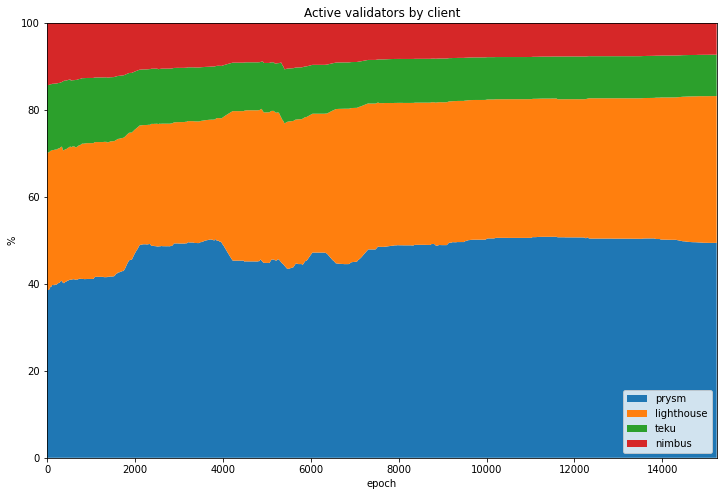

In [7]:
# plot each client's share of active validators by epoch

active_validators = pd.DataFrame({'prysm'     :status_data['prysm']['active'],
                                 'lighthouse':status_data['lighthouse']['active'],
                                 'teku'      :status_data['teku']['active'],
                                 'nimbus'    :status_data['nimbus']['active']})

perc_active_validators = active_validators.divide(active_validators.sum(axis=1), axis=0) * 100

fig=plt.figure(figsize=(12,8))
plt.stackplot(range(len(perc_active_validators.index)), perc_active_validators['prysm'], perc_active_validators['lighthouse'],
              perc_active_validators['teku'], perc_active_validators['nimbus'],labels=['prysm','lighthouse','teku','nimbus'])
              #colors=['tab:blue','tab:red','tab:green','tab:orange'])
plt.legend(loc='lower right')
plt.margins(0,0)
plt.title('Active validators by client')
plt.xlabel('epoch')
plt.ylabel('%')
plt.show()

## Validator Trends
As in our article on [validator taxonomy](/posts/medalla-validator-taxonomy), it may be instructive to look at how validators behaved, including whether they may have been at times *dormant* or *abandoned*, this time broken down by client (NB there will be no *absent* validators this time, as we are only able to consider validators who have successfully proposed at least one block).

The code below aggregates validator performace accross each epoch, as before, but now subdivided by client:

In [8]:
# calculate participation rates, mean inclusion distance and attestation effectiveness for each client
# if the attestation is missed and the validator has not yet done any attestations, it is considered dormant
# if the attestation is missed and there are no future attestations, it is considered abandoned

start_time = time.time()
last_update = 0

success_count   = {client:empty.copy() for client in clients}
absent_count    = {client:empty.copy() for client in clients}
dormant_count   = {client:empty.copy() for client in clients}
abandoned_count = {client:empty.copy() for client in clients}
missed_count    = {client:empty.copy() for client in clients}
sum_distance    = {client:empty.copy() for client in clients}
sum_ae          = {client:empty.copy() for client in clients}
correct_count   = {client:empty.copy() for client in clients}

for slot in range(n_epochs * 32):
    epoch = slot // 32
    cursor.execute(f"SELECT f_validator_index, f_performance, f_effectiveness, f_correct "
                   f"FROM t_validator_performance WHERE f_slot = {slot}")
    result = cursor.fetchone()
    validator_indices  = result[0]
    performance        = result[1]
    effectiveness      = result[2]
    correct            = result[3]
    
    for position, val_index in enumerate(validator_indices):
        client = validators[val_index]["client"]
        if client not in clients:
            continue
        if performance[position] != -1:
            success_count[client][epoch] += 1
            sum_distance[client][epoch]  += performance[position]
            sum_ae[client][epoch]        += effectiveness[position]
            if correct[position] == 1:
                correct_count[client][epoch] += 1
        elif validators[val_index]["latest_attestation"] == -1:
            absent_count[client][epoch]    += 1
        elif epoch < validators[val_index]["first_attestation"]:
            dormant_count[client][epoch] += 1
        elif epoch > validators[val_index]["latest_attestation"]:
            abandoned_count[client][epoch] += 1
        else:
            missed_count[client][epoch]    += 1

    t = time.time()
    if t - last_update > 0.1:
        last_update = t
        seconds = t - start_time
        elapsed = time.strftime("%H:%M:%S",time.gmtime(seconds))
        left = time.strftime("%H:%M:%S",time.gmtime(seconds * ((latest_slot+1) / (slot+1)-1)))
        percentage = 100*(slot+1)/(latest_slot+1)
        print(f"epoch {epoch} of {latest_slot//32} ({percentage:.2f}%) / "
              f"{elapsed} elapsed / {left} left", end='\r')

unresponsive_count = {}
participation_rate = {}
participation_rate_reduced = {}
mean_inclusion_distance = {}
mean_ae = {}
mean_ae_reduced = {}
accuracy = {}
for c in clients:
    unresponsive_count[c] = [absent_count[c][e] + dormant_count[c][e] + abandoned_count[c][e]
                          for e in range(n_epochs)]
    
    participation_rate[c] = [100 * s / (s + missed_count[c][e] + unresponsive_count[c][e])
                             for e, s in enumerate(success_count[c])]
    
    participation_rate_reduced[c] = [100 * s / (s + missed_count[c][e]) for e, s in enumerate(success_count[c])]
    
    mean_inclusion_distance[c] = [d / success_count[c][e] if success_count[c][e] > 0 else None
                                  for e, d in enumerate(sum_distance[c])]
    
    mean_ae[c] = [100 * a / (success_count[c][e] + missed_count[c][e] + unresponsive_count[c][e])
                  for e, a in enumerate(sum_ae[c])]
    
    mean_ae_reduced[c] = [100 * a / (success_count[c][e] + missed_count[c][e]) for e, a in enumerate(sum_ae[c])]
    
    accuracy[c] = [100 * co / success_count[c][e] if success_count[c][e] > 0 else 0
                       for e, co in enumerate(correct_count[c])]
clear_output()
print(f"pass completed in {elapsed}")

pass completed in 00:18:26


Having calcualted validator performance by client, we plot a set of stacked charts below. These seem to indicate some strong differences in behaviour between the clients. Prysm seems to have the highest participation rate, but with  periods where perhaps 20% of their nodes drop offline for 10s of epochs. Lighthouse starts of with quite poor participation, but seems to have the lowest proportion of missed (orange) attesatations from epoch 12000 onwards. Meanwhile Teku shows fairly consistent performance throughout. Nimbus nodes appear to have struggled to attest consistently throughout.

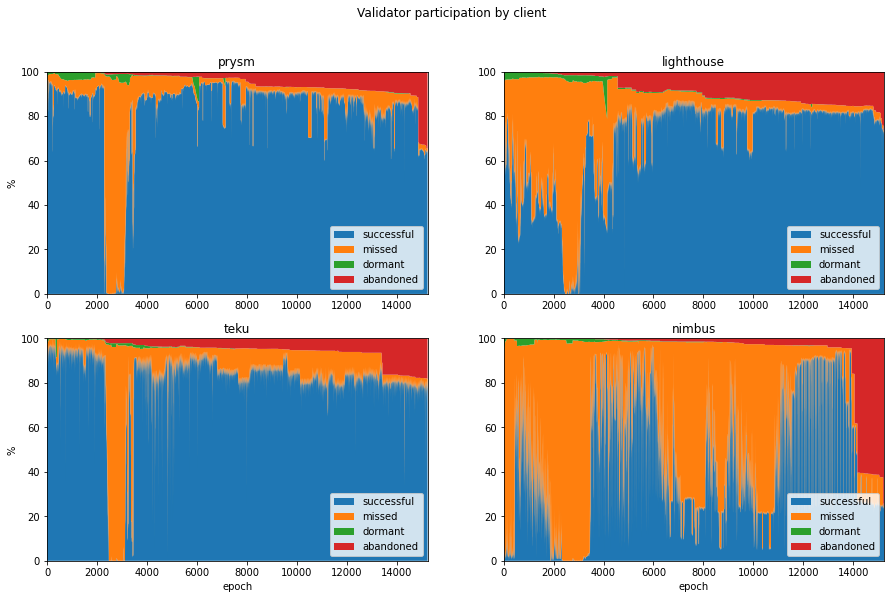

In [9]:
# four stacked plots showing successful/missed/absent/dormant/abandoned for each client

fig, axs = plt.subplots(2, 2, figsize=(15,9))
fig.suptitle('Validator participation by client')
axs = {'prysm': axs[0,0], 'lighthouse': axs[0,1], 'teku':axs[1,0], 'nimbus':axs[1,1]}

participation_data = {}
perc_participation_data = {}
for client in clients:
    participation_data[client] = pd.DataFrame({'successful': success_count[client],
                                               'missed'    : missed_count[client],
                                               'absent'    : absent_count[client],
                                               'dormant'   : dormant_count[client],
                                               'abandoned' : abandoned_count[client]})
    perc_participation_data[client] = participation_data[client].divide(participation_data[client]
                                                                        .sum(axis=1), axis=0) * 100
    axs[client].stackplot(range(len(perc_participation_data[client].index)),
                          perc_participation_data[client]['successful'],
                          perc_participation_data[client]['missed'],
                          perc_participation_data[client]['dormant'],
                          perc_participation_data[client]['abandoned'],
                          labels=['successful','missed','dormant','abandoned'])           
    axs[client].set_title(client)
    if client in ('teku','nimbus'):
        axs[client].set_xlabel('epoch')
    if client in ('prysm','teku'):
        axs[client].set_ylabel('%')
    axs[client].legend(loc='lower right')
    axs[client].margins(0,0)

plt.show()

## Attestation Effectiveness
As before let's now compare the clients on their attestation effectiveness. To show the data more clearly, we'll start from epoch 5000 (after the roughtime incident), and also take a 16-epoch moving average of the numbers.

As shown by the statics, Nimbus falls significantly behind the other two clients with a mean attesatation effectiveness more than 30 percentage points behind the next client. Prysm, Lighthouse and Teku are much closer together, but all clients seem to have "choppy" attestation effectiveness, mirroring what we saw in the stacked participation charts. This may be indicative of clusters of nodes dropping out at intervals.

Attestation Effectiveness statistics (epoch 5000 onwards)

              prysm    lighthouse          teku        nimbus
count  10237.000000  10237.000000  10237.000000  10237.000000
mean      90.907715     89.660945     86.539547     52.680197
std        6.497804      7.425401      5.950800     25.884589
min       36.183543     36.895126     15.379269      4.060734
25%       88.392668     88.719504     83.268301     27.335197
50%       93.113491     91.848963     87.223107     56.444095
75%       95.507576     93.954772     90.372309     75.660009
max       98.400035     98.820932     98.750805     97.112029



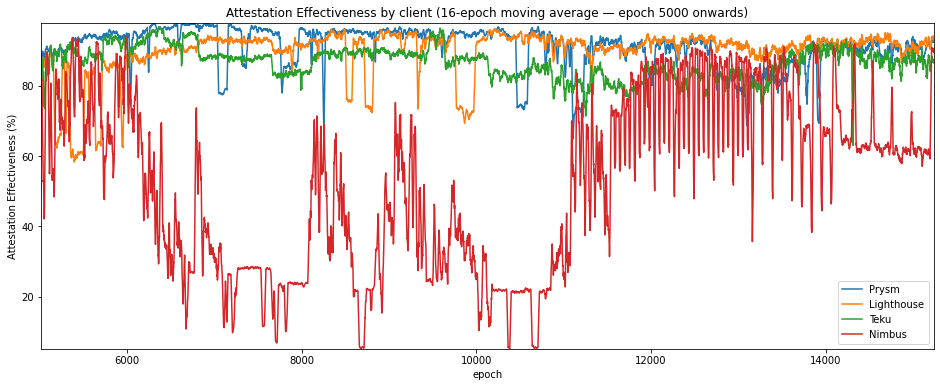

In [10]:
# graphs and stats for attestation effectiveness
ae_df = pd.DataFrame.from_dict(mean_ae_reduced)

print("Attestation Effectiveness statistics (epoch 5000 onwards)\n")
print(ae_df.iloc[5000:].describe(), end='\n\n')

# plot the mean inclusion distance
fig=plt.figure(figsize=(16,6))
plt.plot(ae_df['prysm'].iloc[5000:].rolling(16).mean(), label='Prysm')
plt.plot(ae_df['lighthouse'].iloc[5000:].rolling(16).mean(), label='Lighthouse')
plt.plot(ae_df['teku'].iloc[5000:].rolling(16).mean(), label='Teku')
plt.plot(ae_df['nimbus'].iloc[5000:].rolling(16).mean(), label='Nimbus')
plt.legend(loc='lower right')
plt.margins(0,0)
plt.title('Attestation Effectiveness by client (16-epoch moving average — epoch 5000 onwards)')
plt.xlabel('epoch')
plt.ylabel('Attestation Effectiveness (%)')
plt.show()

## Attestation Accuracy
Now let's consider the other key metric identified in the [network stress](/posts/medalla-network-stress) article, attestation accuracy. Again, we'll focus just on the period from epoch 5000 onwards.

On this metric, Teku seems to come out consistently on top, while Prysm seems to have a significant drop in attestation accuracy between epochs 12000 and 14000.

Attestation Accuracy statistics (epoch 5000 onwards)

              prysm    lighthouse          teku        nimbus
count  10237.000000  10237.000000  10237.000000  10237.000000
mean      93.259509     95.407463     96.654403     85.205451
std        5.717137      3.221890      3.366954     13.282109
min       57.665678     71.553611      7.950117      6.731813
25%       91.200632     93.522815     95.321229     79.691120
50%       94.622237     95.853008     97.030342     88.935574
75%       96.776076     97.910264     99.332889     94.786730
max       99.882843    100.000000    100.000000    100.000000



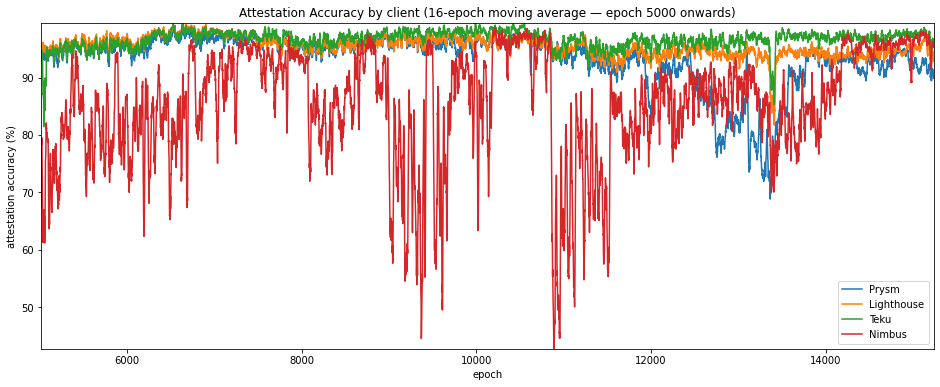

In [11]:
# graphs and stats for attestation accuracy
ac_df = pd.DataFrame.from_dict(accuracy)

print("Attestation Accuracy statistics (epoch 5000 onwards)\n")
print(ac_df.iloc[5000:].describe(), end='\n\n')

# plot the mean inclusion distance
fig=plt.figure(figsize=(16,6))
plt.plot(ac_df['prysm'].iloc[5000:].rolling(16).mean(), label='Prysm')
plt.plot(ac_df['lighthouse'].iloc[5000:].rolling(16).mean(), label='Lighthouse')
plt.plot(ac_df['teku'].iloc[5000:].rolling(16).mean(), label='Teku')
plt.plot(ac_df['nimbus'].iloc[5000:].rolling(16).mean(), label='Nimbus')
plt.legend(loc='lower right')
plt.margins(0,0)
plt.title('Attestation Accuracy by client (16-epoch moving average — epoch 5000 onwards)')
plt.xlabel('epoch')
plt.ylabel('attestation accuracy (%)')
plt.show()

## Client Block/Slash Rates
Finally, we'll look at how the clients compared in terms of the number of canonical blocks they produced. To try to make it a fair comparison, we'll count up the number of blocks produced by each client, and the number of validators from each client which were slashed. We'll then find the rate per million *validator-epochs*, where a validator-epoch is one validator in an *active* state for one epoch. We'll also look at the *reduced* versions of these statistics, which exclude unresponive (dormant/abandoned) validators.

The stats are shown in the table below, and suggest that Prysm and Lighthouse had a significantly better rate of block production than Teku and Nimbus. Nimbus had the highest slash rate (that is, Nimbus clients had the greatest rate of *being* slashed), followed by Prysm. It seems likely that the relatively high Prysm slash-rate is a result a relatively large number of Prysm nodes being slashed during the roughtime incident.

In [12]:
# count up blocks produced and slashing events, per client

# blocks produced
proposed = {client:0 for client in clients}
for v in validators:
    client = v['client']
    if client not in clients:
        continue
    proposed[client] += 1

# slashing events
slashed = {client: 0 for client in clients}
for v in validators:
    client = v['client']
    if client not in clients:
        continue
    if v['slashed']:
        slashed[client] += 1

valepoch_active = {client: 0 for client in clients}
valepoch_unresponsive = {client: 0 for client in clients}

for client in clients:
    for epoch in range(n_epochs):
        valepoch_active[client] += active_count[client][epoch]
        valepoch_unresponsive[client] += unresponsive_count[client][epoch]

block_rate         = {client: 10**6 * proposed[client] / valepoch_active[client] for client in clients}
block_rate_reduced = {client: 10**6 * proposed[client] / (valepoch_active[client] - valepoch_unresponsive[client])
                      for client in clients}
slash_rate         = {client: 10**6 * slashed[client] / valepoch_active[client] for client in clients}
slash_rate_reduced = {client: 10**6 * slashed[client] / (valepoch_active[client] - valepoch_unresponsive[client])
                      for client in clients}

print("per client blocks produced and slashing events (per million epoch-validators)")
print("")
print("client     block rate (reduced) slash rate (reduced)")
print("----------------------------------------------------")
for client in clients:
    row = [block_rate[client], block_rate_reduced[client], slash_rate[client], slash_rate_reduced[client]]
    print(client.ljust(10) + '{:10.2f}'.format(row[0]) + '{:10.2f}'.format(row[1])
          + '{:10.2f}'.format(row[2]) + '{:10.2f}'.format(row[3]))

per client blocks produced and slashing events (per million epoch-validators)

client     block rate (reduced) slash rate (reduced)
----------------------------------------------------
prysm          88.62     95.03      2.15      2.31
lighthouse     88.22     99.27      0.45      0.51
teku           74.69     79.44      0.16      0.17
nimbus         73.37     78.88      3.23      3.47


## Conclusions
So from all the graphs and stats above, we can see that the clients are not all the same. Clear differences in performance were observed across a range of metrics. Interestingly, it wasn't always the same client coming out on top — Prysm, Lighthouse and Teku all showed strengths in different areas and at different times. From the data available so far, the same can't yet be said for Nimbus, which remains in active development.

People considering running validators themselves might want to consider this data as part of their choice of node. They should also remember that [both they and the network will benefit from running a *minority* client](https://blog.ethereum.org/2020/08/21/validated-why-client-diversity-matters/). With three solidly performing clients to choose from, there is already no excuse for being part of the herd.